<a href="https://colab.research.google.com/github/vandana10/deeplearning-using-pytorch/blob/main/neural_network_classification_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Neural network classification with PyTorch
predicting whether something is one thing or another

## 1. Make classification data and get it ready

In [1]:
import sklearn

In [2]:
from sklearn.datasets import make_circles

n_samples = 1000

X,Y=make_circles(n_samples,
                 noise=0.03,
                 random_state=42)

len(X)

1000

In [3]:
print(f"print first 5 samples of X:{X[:5]}")
print(f"print first 5 samples of Y:{Y[:5]}")

print first 5 samples of X:[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
print first 5 samples of Y:[1 1 1 1 0]


In [4]:
import pandas as pd
circles = pd.DataFrame({"X1":X[:,0],
                        "X2":X[:,1],
                        "label":Y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


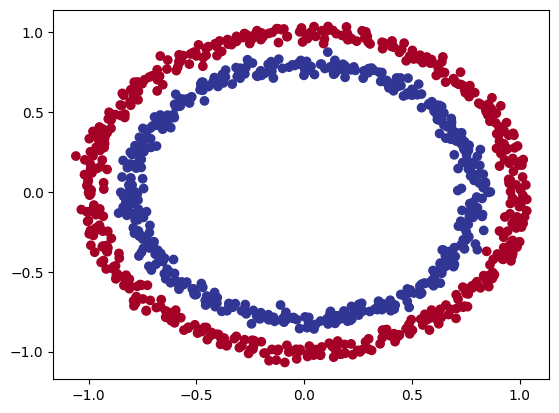

In [5]:
#visialise
import matplotlib.pyplot as plt
plt.scatter(x=X[:,0],
            y=X[:,1],
            c=Y,
            cmap=plt.cm.RdYlBu)

Note: the data we ar eworking with is called as Toy dataset

## Check input and output shapes

In [6]:
X.shape, Y.shape

((1000, 2), (1000,))

In [7]:
X_sample = X[0]
Y_sample = Y[0]

print(f"Values for one sample of X: {X_sample} and the same for Y: {Y_sample}")
print(f"Shape of one sample of X: {X_sample.shape} and the same for Y: {Y_sample.shape}")


Values for one sample of X: [0.75424625 0.23148074] and the same for Y: 1
Shape of one sample of X: (2,) and the same for Y: ()


## Turn data into tensors and create train and test splits

In [8]:
import torch


In [9]:
type(X)

numpy.ndarray

In [10]:
type(X)

numpy.ndarray

In [11]:
X

array([[ 0.75424625,  0.23148074],
       [-0.75615888,  0.15325888],
       [-0.81539193,  0.17328203],
       ...,
       [-0.13690036, -0.81001183],
       [ 0.67036156, -0.76750154],
       [ 0.28105665,  0.96382443]])

## 1. Split data into training and test

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
X_train, X_test, Y_train, Y_test = train_test_split(X,
                                                    Y,
                                                    test_size=0.2, #20% is test and 80% train
                                                    random_state=42)


In [14]:
len(X_train) , len(X_test)

(800, 200)

## 2. Building a model

Lets build a model to classify our blue and red dots

To do so, we want to:
1. Set up device agnostic code
2. Construct a model (by subclassing nn.module)
3. Define a loss function and optimiser
4. Create a training and test loop

In [15]:
import torch
from torch import nn

now lets create a model:
1. Subclasses nn.module
2. create 2 nn.linear() layers that are capable of handling the shapes of our data
3. define a forward() method that outlines the forward pass(or forward computation)
4. Instantiate an instance of our model class and send it to the target device


In [20]:
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()

    self.layer_1 = nn.Linear(in_features=2,
                             out_features=5)
    self.layer_2 = nn.Linear(in_features=5,
                             out_features=1)

  def forward(self,x):
    return self.layer_2(self.layer_1(x))




In [23]:
model_0 = CircleModelV0()

In [40]:
#Make predictions
with torch.inference_mode():
  untrained_preds = model_0(torch.from_numpy(X_test).float())

print(f"Lenght of predictions: {len(untrained_preds)}, shape of predcitions : {untrained_preds.shape}")
print(f"\nLenght of test samples: {len(X_test)}, shape: {X_test.shape}")
print(f"\nFirst 10 predictions: {untrained_preds[:10]}")
print(f"\nFirst 10 labels: {Y_test[:10]}")

Lenght of predictions: 200, shape of predcitions : torch.Size([200, 1])

Lenght of test samples: 200, shape: (200, 2)

First 10 predictions: tensor([[-0.3348],
        [-0.2459],
        [-0.4513],
        [-0.3023],
        [-0.2664],
        [-0.2136],
        [-0.1098],
        [-0.1018],
        [-0.4589],
        [-0.2379]])

First 10 labels: [1 0 1 0 1 1 0 0 1 0]


### 2.1 Set up loss functions and optimiser

which loss function or optimiser should you use?

For regression: MAE or MSE (mean abs error or mean squared error)

For classification: Binary cross entropy or categorial cross entropy

In [41]:
loss_fn = nn.BCEWithLogitsLoss() #has in-built sigmoid activation function

optimiser = torch.optim.SGD(params = model_0.parameters(),
                            lr=0.01)


In [42]:
#Calc accuracy- out of 100 examples, what % does our model get right?
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred))*100
  return acc

## Train our model

1. Forward pass
2. Calc the loss
3. Optimiser zero grad
4. Loss backward(back propagation)
5. Optimiser (gradient descent)

### Going from raw logits -> Prediction proabilities -> prediction lables

Model outputa raw **logits**

Need to convert them into prediction proablilites by passing them into **Activation functions** (eg, sigmoid for binary classification and softmax for multiclass classification)

then from predcition proablities to lables, we can either round them or take argmax()

In [44]:
#View the first 5 outputs of forward pass on the test data
with torch.inference_mode():
  y_logits = model_0(torch.from_numpy(X_test).float())
y_logits[:5]



tensor([[-0.3348],
        [-0.2459],
        [-0.4513],
        [-0.3023],
        [-0.2664]])

In [45]:
#Use sigmoid activation fn
y_preds_probs = torch.sigmoid(y_logits)
y_preds_probs[:5]

tensor([[0.4171],
        [0.4388],
        [0.3890],
        [0.4250],
        [0.4338]])

For our predcition proability values, we need to perform a range style rounding on them:
1. y_preds_probs >= 0.5 , y=1 (class 1)
2. y_preds_probs < 0.5, y=0 (class 0)

In [49]:
#Find the prediction labels
y_preds = torch.round(y_preds_probs)

y_pred_labels = torch.round(torch.sigmoid(model_0(torch.from_numpy(X_test).float())))

#print(torch.eq(y_preds, y_pred_labels))

#y_preds.squeeze()

###Build a training and testing loop

In [71]:
torch.manual_seed(42)

epochs = 1000

for epoch in range(epochs):
  model_0.train()

  y_logits = model_0(torch.from_numpy(X_train).float()).squeeze()
  y_preds = torch.round(torch.sigmoid(y_logits)) #turns logits -> pred probs -> pred labels

  # nn.BCEWithLogitsLoss expects logits as input
  #loss = loss_fn(torch.sigmoid(y_logits),
  #                Y_train)
  loss = loss_fn(y_logits,
                 torch.from_numpy(Y_train).float())

  acc = accuracy_fn(y_true=torch.from_numpy(Y_train),
                    y_pred=y_preds)

  optimiser.zero_grad()

  loss.backward()

  optimiser.step()

  #testing
  model_0.eval()
  with torch.inference_mode():
    test_logits = model_0(torch.from_numpy(X_test).float()).squeeze()
    test_preds = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits,
                        torch.from_numpy(Y_test).float())
    test_acc = accuracy_fn(y_true=torch.from_numpy(Y_test),
                           y_pred=test_preds)

  #print
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.5f}% | Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.5f}%")




Epoch: 0 | Loss: 0.69334 | Acc: 48.37500% | Test Loss: 0.69494 | Test Acc: 49.50000%
Epoch: 100 | Loss: 0.69322 | Acc: 49.12500% | Test Loss: 0.69476 | Test Acc: 49.50000%
Epoch: 200 | Loss: 0.69314 | Acc: 49.12500% | Test Loss: 0.69467 | Test Acc: 49.00000%
Epoch: 300 | Loss: 0.69310 | Acc: 49.87500% | Test Loss: 0.69462 | Test Acc: 48.50000%
Epoch: 400 | Loss: 0.69306 | Acc: 50.25000% | Test Loss: 0.69459 | Test Acc: 48.00000%
Epoch: 500 | Loss: 0.69304 | Acc: 49.87500% | Test Loss: 0.69457 | Test Acc: 48.50000%
Epoch: 600 | Loss: 0.69302 | Acc: 50.62500% | Test Loss: 0.69457 | Test Acc: 48.00000%
Epoch: 700 | Loss: 0.69301 | Acc: 50.50000% | Test Loss: 0.69457 | Test Acc: 47.50000%
Epoch: 800 | Loss: 0.69300 | Acc: 50.87500% | Test Loss: 0.69457 | Test Acc: 47.00000%
Epoch: 900 | Loss: 0.69300 | Acc: 51.12500% | Test Loss: 0.69458 | Test Acc: 46.00000%


## Make predctions and evaluate the model

From the metrics it looks like it isnt learning anything

In [72]:
import requests
from pathlib import Path

#Download helper functions from learn pytorch repo
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)



helper_functions.py already exists


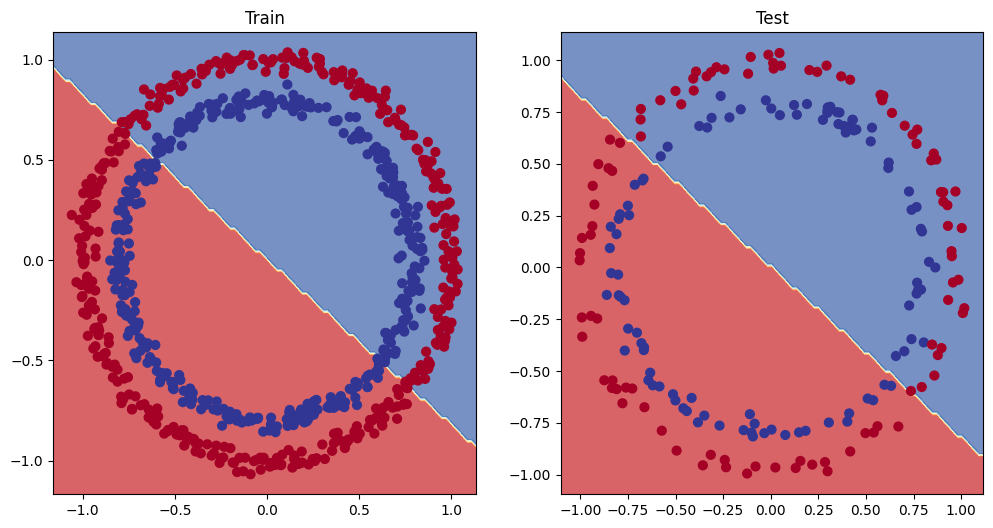

In [73]:
# plot decision boundary of the model
from helper_functions import plot_predictions, plot_decision_boundary

X_train_tensor = torch.from_numpy(X_train).float()
Y_train_tensor = torch.from_numpy(Y_train).float()

X_test_tensor = torch.from_numpy(X_test).float()
Y_test_tensor = torch.from_numpy(Y_test).float()

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0, X_train_tensor, Y_train_tensor)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0, X_test_tensor, Y_test_tensor)